In [151]:
'''
In this file, we calculate the von neumann entropy of a series of diagrams. 

We compare them to each other in the hope of finding that more ambiguous (less disambiguated sentences) have higher entropy. 

'''



'\nIn this file, we calculate the von neumann entropy of a series of diagrams. \n\nWe compare them to each other in the hope of finding that more ambiguous (less disambiguated sentences) have higher entropy. \n\n'

In [152]:
'''
start by importing all sorts of stuff
'''


import numpy as np
from sympy import Symbol, symbols

from lambeq.ansatz import BaseAnsatz
from lambeq.backend.grammar import Box, Diagram, Functor, Ty
from lambeq.backend.quantum import (
    Bra,
    CRz,
    Diagram as Circuit,
    Discard,
    H,
    CX,
    Id,
    Ket,
    quantum,
    qubit,
    Rotation,
    Rx, Ry, Rz
)

from lambeq import AtomicType


In [153]:
'''
Note that for this program, we do not have to import test data. 
We test the entropy for sentences crafted in the program especially for the program. 

We write three functions for three types of sentences: 
1. The normal way of parsing 
2. Alice runs and Bob does too 
3. Alice cooks food and eats it. 
'''

from lambeq import BobcatParser
parser = BobcatParser(verbose='text')
from lambeq import RemoveCupsRewriter
remove_cups = RemoveCupsRewriter()
from lambeq import AtomicType, IQPAnsatz
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq import AtomicType
N = AtomicType.NOUN
S = AtomicType.SENTENCE
n, s = Ty('n'), Ty('s')

# create three functions for three types of diagrams

def GijsDiag(sentence:str): 
    '''
    This function, given a sentence of the form: 
    Subj Verb Obj and Subj* does too
    , returns a diagram that copies the information in such a way that the returned diagram reads: 
    Subj Verb Obj and Subj* Verb Obj
    The object will be removed later to work with density matrices. 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 2, 1) @ Id(n.r) @ Id(s) @ Cup(n.l, n) >> 
            Cup(n, n.r) @ Id(s) )
    newWords = [
        Word(wordList[0], n),
        # Word('test', n),
        Word(wordList[4], n),
        Word(wordList[1], n.r @ s @ n.l), 
        Word(wordList[2], n)
    ]

    diagram = Id().tensor(*newWords) >> grammar
    diagram = remove_cups(diagram)
    # diagram.draw()

    circuit = ansatz(diagram= diagram)

    return circuit#, diagram 

def NaiveDiag(sentence:str):
    '''
    Simply returns a naive circuit given a diagram
    '''
    diagram = parser.sentence2diagram(sentence= sentence, suppress_exceptions=True)

    diagram = remove_cups(diagram)

    # diagram.draw()

    circuit = ansatz(diagram= diagram)

    return circuit#, diagram

def AmbiguousVerb(sentence:str):
    '''
    This function, given a sentence like: 
    Subj Verb Obj and Verb* it. (Man prepares dinner and eats it.) 
    returns a diagram that copies the information, so that: 
    Subj Verb Obj and Subj Verb* Obj
    The object will be removed later 
    '''
    wordList = sentence.split()
    grammar = (Spider(n, 1, 2) @ Id(n.r) @ Id(s) @ Id(n.l) @ Spider(n, 1, 2)  >> 
                Id(n) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Id(n) >> 
                Id(n) @ Word(wordList[4], n.r @ s @ n.l) @ Id(s) @ Id(n) >> 
                Cup(n, n.r) @ Id(s) @ Swap(n.l, s) @ Id(n) >> 
                Spider(s, 2, 1) @ Cup(n.l, n))
    newWords = [
        Word(wordList[0], n),
        Word(wordList[1], n.r @ s @ n.l),
        Word(wordList[2], n)
    ]


    diagram = Id().tensor(*newWords) >> grammar
    diagram = remove_cups(diagram)
    # diagram.draw()
    circuit = ansatz(diagram= diagram)

    return circuit#, diagram


    




In [154]:
def AmbiguousVerb2(sentence:str): 
    '''
    
    '''
    wordList = sentence.split()
    newWords = [
        # Word(wordList[0], n),
        Word(wordList[1], n.r @ s @ n.l),
        Word(wordList[4], n.r @ s @ n.l),
        # Word(wordList[2], n)
    ]

    grammar = (
        Id(n.r) @ Id(s) @ Swap(n.l, n.r) @ Id(s) @ Id(n.l) >> 
        Id(n.r) @ Swap(s, n.r) @ Swap(n.l, s) @ Id(n.l) >> 
        Spider(n.r, 2, 1) @ Spider(s, 2, 1) @ Spider(n.l, 2, 1) >> 
        Word(wordList[0], n.r).dagger() @ Id(s) @ Word(wordList[2], n.l).dagger()
    )


    # grammar = (
    #     Spider(n, 1, 2) @ Id(n.r) @ Id(s) @ Id(n.l) @ Id(n.r) @ Id(s) @ Id(n.l) @ Spider(n, 1, 2) >>
    #     Id(n) @ Cup(n, n.r) @ Id(s) @ Id(n.l) @ Id(n.r) @ Id(s) @ Cup(n.l, n) @ Id(n) 
    # )

    diagram = Id().tensor(*newWords) >> grammar
    # diagram = remove_cups(diagram)
    diagram.draw()
    circuit = ansatz(diagram= diagram)

    return circuit#, diagram

In [155]:

GIJS = True  

naiveSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal', 'person reads meal', 'person runs meal'
                'person prepares dinner', 'person cooks dinner', 'person bakes dinner', 'person reads dinner', 'person runs dinner',
                'person prepares sauce', 'person cooks sauce', 'person bakes sauce', 'person reads sauce', 'person runs sauce',
                'person prepares program', 'person cooks program', 'person bakes program', 'person reads program', 'person runs program',
                'person prepares software', 'person cooks software', 'person bakes software', 'person reads software', 'person runs software',
                'person prepares application', 'person cooks application', 'person bakes application', 'person reads application', 'person runs application',
                ]





if not GIJS: 

    senseFulSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal',
                    'person prepares dinner', 'person cooks dinner', 'person bakes dinner',
                    'person prepares sauce', 'person cooks sauce', 'person bakes sauce',
                    'person prepares program', 'person reads program', 'person runs program',
                    'person prepares software', 'person reads software', 'person runs software',
                    'person prepares application', 'person reads application', 'person runs application',
                    'man prepares meal', 'man cooks meal', 'man bakes meal',
                    'man prepares dinner', 'man cooks dinner', 'man bakes dinner',
                    'man prepares sauce', 'man cooks sauce', 'man bakes sauce',
                    'man prepares program', 'man reads program', 'man runs program',
                    'man prepares software', 'man reads software', 'man runs software',
                    'man prepares application', 'man reads application', 'man runs application',
                    'woman prepares meal', 'woman cooks meal', 'woman bakes meal',
                    'woman prepares dinner', 'woman cooks dinner', 'woman bakes dinner',
                    'woman prepares sauce', 'woman cooks sauce', 'woman bakes sauce',
                    'woman prepares program', 'woman reads program', 'woman runs program',
                    'woman prepares software', 'woman reads software', 'woman runs software',
                    'woman prepares application', 'woman reads application', 'woman runs application',
                    ]
    
    mySentences = ['person prepares meal and cooks it', 'person prepares meal and bakes it', 'person prepares meal and reads it', 'person prepares meal and runs it',
                    'man prepares meal and cooks it', 'man prepares meal and bakes it', 'man prepares meal and reads it', 'man prepares meal and runs it',
                    'woman prepares meal and cooks it', 'woman prepares meal and bakes it', 'woman prepares meal and reads it', 'woman prepares meal and runs it']


# gijs doesn't know words man, woman 
if GIJS:
    senseFulSentences = ['person prepares meal', 'person cooks meal', 'person bakes meal',
                    'person prepares dinner', 'person cooks dinner', 'person bakes dinner',
                    'person prepares sauce', 'person cooks sauce', 'person bakes sauce',
                    'person prepares program', 'person reads program', 'person runs program',
                    'person prepares software', 'person reads software', 'person runs software',
                    'person prepares application', 'person reads application', 'person runs application',
                    'chef prepares meal', 'chef cooks meal', 'chef bakes meal',
                    'chef prepares dinner', 'chef cooks dinner', 'chef bakes dinner',
                    'chef prepares sauce', 'chef cooks sauce', 'chef bakes sauce',
                    'programmer prepares program', 'programmer reads program', 'programmer runs program',
                    'programmer prepares software', 'programmer reads software', 'programmer runs software',
                    'programmer prepares application', 'programmer reads application', 'programmer runs application'
                    ]



    mySentences = ['person prepares meal and cooks it', 'person prepares meal and bakes it', 'person prepares meal and reads it', 'person prepares meal and runs it']




# we disambiguate the first sentence using the second one 
gijsSentences = ['person prepares meal and chef does too', 'person prepares meal and programmer does too', 'person prepares meal and person does too']



naiveCircuits = []
gijsCircuits  = []
myCircuits    = []


for nS in senseFulSentences: 
    naiveCircuits.append(NaiveDiag(nS))

for gS in gijsSentences: 
    gijsCircuits.append(GijsDiag(gS))

for mS in mySentences: 
    myCircuits.append(AmbiguousVerb(mS))


  

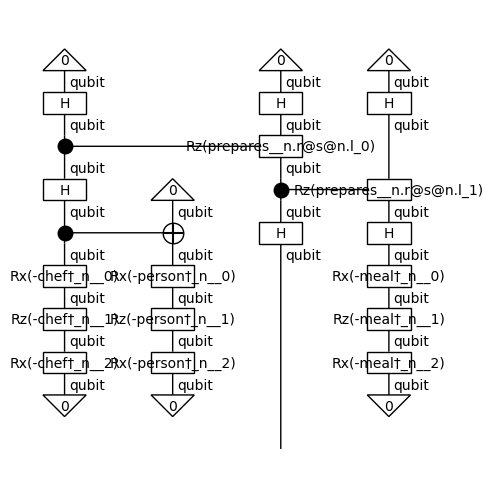

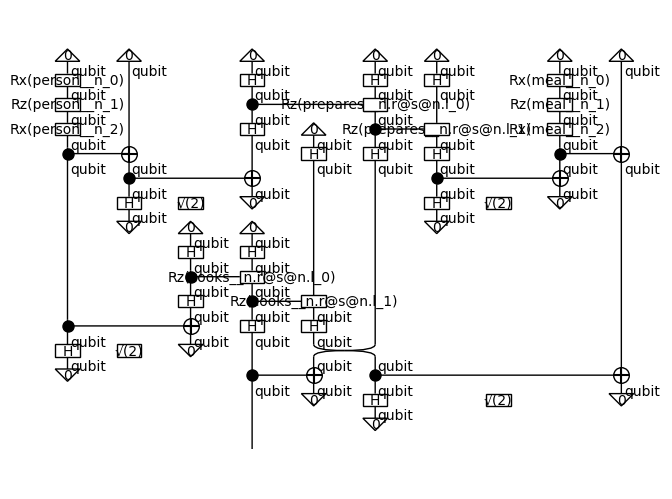

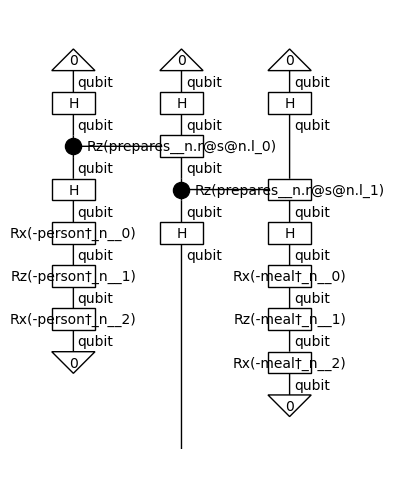

In [156]:
# for circuit in naiveCircuits: 
#     circuit.draw()
# gijsDiags[0].draw()
gijsCircuits[0].draw()
myCircuits[0].draw()
naiveCircuits[0].draw()

In [157]:
'''
import the functions needed to set up the diagrams using the trained weights 
'''

from entropyHelpers import *


In [158]:
'''
import trained weights 
'''
# one of these two is wordsToForget
wordsToForgetSubj = ['man', 'woman', 'person', 'chef', 'programmer']
wordsToForgetObj  = ['dinner', 'meal', 'sauce', 'program', 'application', 'software']


# don't use these words together with chef or something. 
# do not use words in the same list taht appear in the same sentence(s) together

# load dictionary with pickle
import pickle 

# also AE is an option: 
AE = True

# GIJS = False

if not AE: 
    if GIJS: 
        # Numpymodel 
        with open('../weights/weightsDictNP1QB_gijs_500.pkl', 'rb') as fp: 
            parameterDictNP = pickle.load(fp)

        # Numpymodel 
        with open('../weights/weightsDictTK1QB_gijs_500.pkl', 'rb') as fp: 
            parameterDictTK = pickle.load(fp)

        # Pennylane model 
        with open('../weights/weightsDictPL1QB_gijs_500.pkl', 'rb') as fp: 
            parameterDictPL = pickle.load(fp)

    if not GIJS: 
        # Numpymodel 
        with open('../weights/weightsDictNP1QB_500.pkl', 'rb') as fp: 
            parameterDictNP = pickle.load(fp)

        # TKet model 
        with open('../weights/weightsDictTK1QB_500.pkl', 'rb') as fp: 
            parameterDictTK = pickle.load(fp)

        # Pennylane model 
        with open('../weights/weightsDictPL1QB_500.pkl', 'rb') as fp: 
            parameterDictPL = pickle.load(fp)

 

if AE: 
    # Numpymodel 
    with open('../weights/weightsDict_NP_1QB_AE_500_gijs.pkl', 'rb') as fp: 
        parameterDictNP = pickle.load(fp)

    # TKet model 
    with open('../weights/weightsDict_TK_1QB_AE_500_gijs.pkl', 'rb') as fp: 
        parameterDictTK = pickle.load(fp)

    # Pennylane model 
    with open('../weights/weightsDict_PL_1QB_AE_500_gijs.pkl', 'rb') as fp: 
        parameterDictPL = pickle.load(fp)


print(parameterDictNP)


{'bakes__n.r@s@n.l_0': 0.33551560476558906, 'bakes__n.r@s@n.l_1': 0.7172257838442746, 'cooks__n.r@s@n.l_0': 0.4306531189949587, 'cooks__n.r@s@n.l_1': 0.8466301455401205, 'prepares__n.r@s@n.l_0': 0.8606360385553892, 'prepares__n.r@s@n.l_1': 0.595505338999644, 'reads__n.r@s@n.l_0': 0.830502516928964, 'reads__n.r@s@n.l_1': 0.8482639099644077, 'runs__n.r@s@n.l_0': 1.0478535349709972, 'runs__n.r@s@n.l_1': 0.8975000577889296, 'skillful†_n@n.l__0': 0.9410437778073346, 'tasty†_n@n.l__0': 0.6813356414275431, 'useful†_n@n.l__0': 0.5150674745512449}


In [159]:
'''
apply the functions
'''

# parameterDict = parameterDictNP
parameterDict = parameterDictTK
# parameterDict = parameterDictPL

print(parameterDict)

naiveDMListForgetSubj = []
naiveDMListForgetObj  = []
gijsDMListForgetObj = []
gijsDMListForgetSubj = []
myDMListForgetSubj = []
myDMListForgetObj  = [] 

for nC in naiveCircuits: 
    naiveDMListForgetSubj.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetSubj, amplitudeEncoded = AE)[0])
    naiveDMListForgetObj.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj, amplitudeEncoded = AE)[0])
    # naiveDMList.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetSubj)[0])




# commented this out

if GIJS:
    print('GIJS')
    for gC in gijsCircuits: 
        gijsDMListForgetObj.append(Main(listOfCircuits= [gC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj, amplitudeEncoded = AE)[0])
        gijsDMListForgetSubj.append(Main(listOfCircuits= [gC], parameterDict= parameterDict, wordsToForget=wordsToForgetSubj, amplitudeEncoded = AE)[0])

print('MY')

for mC in myCircuits:
    myDMListForgetSubj.append(Main(listOfCircuits= [mC], parameterDict= parameterDict, wordsToForget=wordsToForgetSubj, amplitudeEncoded = AE)[0])
    myDMListForgetObj.append(Main(listOfCircuits= [mC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj, amplitudeEncoded = AE)[0])
    # myDMList.append(Main(listOfCircuits= [mC], parameterDict= parameterDict, wordsToForget=wordsToForgetSubj)[0])


{'bakes__n.r@s@n.l_0': 0.33551560476558906, 'bakes__n.r@s@n.l_1': 0.7172257838442746, 'cooks__n.r@s@n.l_0': 0.4306531189949587, 'cooks__n.r@s@n.l_1': 0.8466301455401205, 'prepares__n.r@s@n.l_0': 0.8606360385553892, 'prepares__n.r@s@n.l_1': 0.595505338999644, 'reads__n.r@s@n.l_0': 0.830502516928964, 'reads__n.r@s@n.l_1': 0.8482639099644077, 'runs__n.r@s@n.l_0': 1.0478535349709972, 'runs__n.r@s@n.l_1': 0.8975000577889296, 'skillful†_n@n.l__0': 0.9410437778073346, 'tasty†_n@n.l__0': 0.6813356414275431, 'useful†_n@n.l__0': 0.5150674745512449}
iteration number:  0


circuit that we start with: 
     ┌───┐                                               ┌───┐              »
q_0: ┤ H ├────────────────■──────────────────────────────┤ H ├──────────────»
     ├───┤┌───────────────┴───────────────┐              └───┘              »
q_1: ┤ H ├┤ Rz(2*π*prepares__n.r@s@n.l_0) ├────────────────■────────────────»
     ├───┤└───────────────────────────────┘┌───────────────┴───────────────┐»
q_2: ┤ H ├─────────────────────────────────┤ Rz(2*π*prepares__n.r@s@n.l_1) ├»
     └───┘                                 └───────────────────────────────┘»
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────────────────────┐┌───────────────────────┐»
«q_0: ┤ Rx(-2*π*person†_n__0) ├┤ Rz(-2*π*person†_n__1) ├»
«     └─────────┬───┬─────────┘└───────────────────────┘»
«q_1: ──────────┤ H ├───────────────────────────────────»
«               ├───┤           ┌────

In [160]:
from qiskit.quantum_info import entropy, purity
print(myDMListForgetObj)
naiveEntropyListForgetSubj = []
naiveEntropyListForgetObj  = []
gijsEntropyListForgetObj  = []
gijsEntropyListForgetSubj = []
myEntropyListForgetSubj    = []
myEntropyListForgetObj     = []

for dM1 in naiveDMListForgetSubj: 
    naiveEntropyListForgetSubj.append(entropy(dM1[0]))

for dM2 in naiveDMListForgetObj: 
    naiveEntropyListForgetObj.append(entropy(dM2[0]))

for dM in gijsDMListForgetObj: 
    gijsEntropyListForgetObj.append(entropy(dM[0]))

for dM in gijsDMListForgetSubj: 
    gijsEntropyListForgetSubj.append(entropy(dM[0]))

for dM3 in myDMListForgetSubj: 
    myEntropyListForgetSubj.append(entropy(dM3[0]))

for dM4 in myDMListForgetObj: 
    myEntropyListForgetObj.append(entropy(dM4[0]))



naivePurityListForgetSubj = []
naivePurityListForgetObj  = []
gijsPurityList  = []
myPurityListForgetSubj    = []
myPurityListForgetObj     = []


# for dM in naiveDMListForgetSubj: 
#     naivePurityListForgetSubj.append(purity(dM[0]))

# for dM in naiveDMListForgetObj: 
#     naivePurityListForgetObj.append(purity(dM[0]))

# # for dM in gijsDMList: 
# #     gijsPurityList.append(purity(dM[0]))

# for dM in myDMListForgetSubj: 
#     myPurityListForgetSubj.append(purity(dM[0]))

# for dM in myDMListForgetObj: 
#     myPurityListForgetObj.append(purity(dM[0]))

# dM = test[0]

# print('entropy: ', entropy(dM))

# print('type: ', type(dM))

# import qiskit.quantum_info as qi
# print('purity: ', qi.purity(dM))




[[DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               ...,
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))], [DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               ...,
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
              dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))], [DensityM

In [161]:




# for i in range(len(senseFulSentences)):
#     print(senseFulSentences[i])
#     print('forget subject, entropy: ', naiveEntropyListForgetSubj[i])
#     print('forget object, entropy: ', naiveEntropyListForgetObj[i])


objList = []
subjList = []
for i in range(len(senseFulSentences)):
    if 'prepares' in senseFulSentences[i]:
        objList.append(naiveEntropyListForgetObj[i])
        subjList.append(naiveEntropyListForgetSubj[i])

print('forget object: ')
print(sum(objList)/len(objList))

print('forget subject: ')
print(sum(subjList)/ len(subjList))
# print(myEntropyListForgetObj)
print('avg entropy myDMs: ', sum(myEntropyListForgetObj)/len(myEntropyListForgetObj))
print('avg entropy myDMs: ', sum(myEntropyListForgetSubj)/len(myEntropyListForgetSubj))


if GIJS:
    print(sum(gijsEntropyListForgetObj)/ len(gijsEntropyListForgetObj))
    print(sum(gijsEntropyListForgetSubj)/ len(gijsEntropyListForgetSubj))


for i in range(len(gijsSentences)):
    print(gijsSentences[i])
    print(gijsEntropyListForgetObj[i])
    print(gijsEntropyListForgetSubj[i])

# for i in range(len(mySentences)):
#     print(mySentences[i])
#     print('forget subject, entropy: ', myEntropyListForgetSubj[i])
#     print('forget object, entropy: ', myEntropyListForgetObj[i])



print('purities: ')

# for i in range(len(naiveSentences)):
#     print(naiveSentences[i])
#     print('forget subject, entropy: ', naivePurityListForgetSubj[i])
#     print('forget object, entropy: ', naivePurityListForgetObj[i])

# for i in range(len(mySentences)):
#     print(mySentences[i])
#     print('forget subject, entropy: ', myPurityListForgetSubj[i])
#     print('forget object, entropy: ', myPurityListForgetObj[i])



forget object: 
0.9360362603874873
forget subject: 
0.05147699214270653
avg entropy myDMs:  0.21109615497271222
avg entropy myDMs:  0.08396109657890888
0.9360362603874873
2.7999982179860654e-15
purities: 


In [162]:
'''
Results of Von Neumann Entropy 
'''

print('Naive entropy: ', naiveEntropyList)

print('Gijs entropy: ', gijsEntropyList)

print('My entropy:', myEntropyList)

print('Naive purity: ', naivePurityList)

print('Gijs purity: ', gijsPurityList)

print('My purity:', myPurityList)

NameError: name 'naiveEntropyList' is not defined

In [ ]:
'''
Calculate fidelity between two density matrices
'''

def Fidelity(rho, sigma): 

    # from sklearn.preprocessing import normalize

    # rho = normalize(rho, norm = 'l1')
    # sigma = normalize(sigma, norm = 'l1')

    print('trace rho: ', np.trace(rho))
    print('trace sigma: ', np.trace(sigma))

    # first approach 
    partI = np.matmul(sigma, np.sqrt(rho))
    partII = np.sqrt( np.matmul(np.sqrt(rho), partI) )
    partIII = np.trace(partII)
    


    # # second approach via trace norm
    # partIII = np.trace(abs(np.dot( np.sqrt(rho), np.sqrt(sigma)))) ** 2

    
    return abs(partIII)



In [ ]:
from qiskit.quantum_info import state_fidelity

print('fidelity between naive and gijs: ', Fidelity(naiveDMList[0][0].data, gijsDMList[0][0].data))

print('fidelity between naive and my: ', Fidelity(naiveDMList[0][0].data, myDMList[0][0].data))

print('fidelity between gijs and my: ', Fidelity(gijsDMList[0][0].data, myDMList[0][0].data))

print('Qiskit says the followin: ')
print('Naive, Gijs: ', state_fidelity(naiveDMList[0][0], gijsDMList[0][0]))
print('naive, me', state_fidelity(naiveDMList[0][0], myDMList[0][0]))


print('Trace Distance')
print('naive,Gijs: ', TraceDistance(naiveDMList[0][0], gijsDMList[0][0]))
print('naive, me', TraceDistance(naiveDMList[0][0], myDMList[0][0]))

print('naive, naive', TraceDistance(naiveDMList[0][0], naiveDMList[0][0]))

trace rho:  (0.999999999999999-2.6020852139652106e-17j)
trace sigma:  (0.9999999999999989-8.673617379884035e-19j)
fidelity between naive and gijs:  1.3725513130168765
trace rho:  (0.999999999999999-2.6020852139652106e-17j)
trace sigma:  (0.9999999999999967-8.600676096676054e-19j)
fidelity between naive and my:  1.2795931019419502
trace rho:  (0.9999999999999989-8.673617379884035e-19j)
trace sigma:  (0.9999999999999967-8.600676096676054e-19j)
fidelity between gijs and my:  1.2795931019419502
Qiskit says the followin: 
Naive, Gijs:  0.9999999999999982
naive, me 0.6723998023742271
Trace Distance
naive,Gijs:  6.158100243832224e-17
naive, me 0.3326145815005375
naive, naive 0.0


In [ ]:
def TraceDistance(rho, sigma):
    '''
    this is another measure to compare density matrices 
    ''' 
    newMatrix = rho - sigma

    absValue = np.sqrt(newMatrix)

    return 1/2 * np.trace(np.abs(newMatrix))


In [ ]:
'''
We continue by comparing the density matrices to how far away they are from the two Categories 
'''

iTMatrix = np.array([[1,0], [0,0]])
foodMatrix = np.array([[0,0], [0,1]])

In [ ]:
iTDM = DensityMatrix(iTMatrix)
foodDM = DensityMatrix(foodMatrix)

In [ ]:
print(iTDM)
print(foodDM)

DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 0.+0.j]],
              dims=(2,))
DensityMatrix([[0.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))


In [ ]:
print(state_fidelity(myDMList[0][0], iTDM))

0.99996362188814


In [ ]:
def SpectralDecomposition(rho):

    eigenvalues, eigenvectors = np.linalg.eig(rho)
    # rhoDiagonalized = np.diag(eigenvalues)

    normalizedEvs = []
    for eV in eigenvectors: 
        normalizedEvs.append(eV / np.linalg.norm(eV))


    projectors = []

    for eV in normalizedEvs: 
        projectors.append(np.outer((eV), eV))

    return eigenvalues, projectors

    


In [ ]:
def SpiderAnd(rho, sigma): 
    '''
    ...
    '''
    return np.matmul(rho, sigma)

def Fuzz(rho, sigma): 
    '''
    ...
    '''
    eVList, projectors = SpectralDecomposition(sigma)

    print('testetsetse')
    print(projectors[0] * projectors[0])

    termOne = eVList[0] * ( np.matmul(np.matmul(projectors[0], rho), projectors[0])) 
    termTwo = eVList[1] * ( np.matmul(np.matmul(projectors[1], rho), projectors[1]))  

    return termOne + termTwo


def Phaser(rho, sigma): 
    '''
    ...
    '''
    return np.matmul(np.sqrt(sigma), np.matmul(rho, np.sqrt(sigma)))

In [ ]:
result = SpiderAnd()

(array([1., 1.]), [array([[1., 0.],
       [0., 0.]]), array([[0., 0.],
       [0., 1.]])])


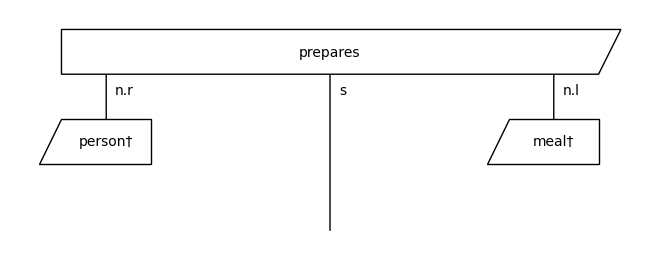

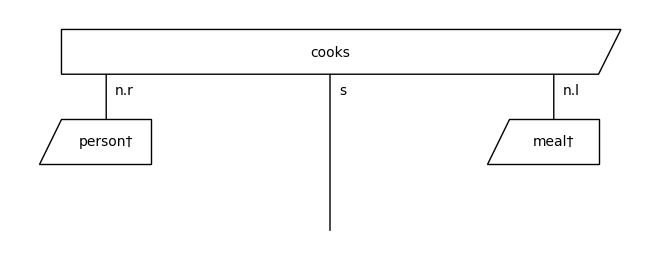

iteration number:  0
circuit that we start with: 
     ┌───┐                                               ┌───┐              »
q_0: ┤ H ├────────────────■──────────────────────────────┤ H ├──────────────»
     ├───┤┌───────────────┴───────────────┐              └───┘              »
q_1: ┤ H ├┤ Rz(2*π*prepares__n.r@s@n.l_0) ├────────────────■────────────────»
     ├───┤└───────────────────────────────┘┌───────────────┴───────────────┐»
q_2: ┤ H ├─────────────────────────────────┤ Rz(2*π*prepares__n.r@s@n.l_1) ├»
     └───┘                                 └───────────────────────────────┘»
c: 2/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────────────────────┐┌───────────────────────┐»
«q_0: ┤ Rx(-2*π*person†_n__0) ├┤ Rz(-2*π*person†_n__1) ├»
«     └─────────┬───┬─────────┘└───────────────────────┘»
«q_1: ──────────┤ H ├───────────────────────────────────»
«               

/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


removed measurement. 
trace out instead of measure, circuit is: 
     ┌───┐                  ┌───┐     ┌────────────┐┌─────────────┐»
q_0: ┤ H ├──────■───────────┤ H ├─────┤ Rx(4.2496) ├┤ Rz(-6.9494) ├»
     ├───┤┌─────┴──────┐    └───┘     └───┬───┬────┘└─────────────┘»
q_1: ┤ H ├┤ Rz(9.7485) ├──────■───────────┤ H ├────────────────────»
     ├───┤└────────────┘┌─────┴──────┐    ├───┤                    »
q_2: ┤ H ├──────────────┤ Rz(8.9996) ├────┤ H ├────────────────────»
     └───┘              └────────────┘    └───┘                    »
c: 2/══════════════════════════════════════════════════════════════»
                                                                   »
«     ┌────────────┐
«q_0: ┤ Rx(3.2177) ├
«     └────────────┘
«q_1: ──────────────
«                   
«q_2: ──────────────
«                   
«c: 2/══════════════
«                   
And traceList is:  [0, 2]
debug, shape density matrtix:  DensityMatrix([[ 0.02337795-2.64274280e-19j, -0.00093358+7.41165040e

In [ ]:
sentencePairOne  = ['person prepares meal', 'person cooks meal']

parameterDict = parameterDictTK

circuits = []
for i in range(len(sentencePairOne)): 
    circuits.append(NaiveDiag(sentencePairOne[i]))

dMList = []

for nC in circuits: 
    dMList.append(Main(listOfCircuits= [nC], parameterDict= parameterDict, wordsToForget=wordsToForgetObj)[0])

In [ ]:
dM1 = dMList[0][0]
dM2 = dMList[1][0]

print(entropy(dM1))
print(entropy(dM2))



0.9991655800075389
0.5379926467308377


In [ ]:
test1 = SpiderAnd(dM1, dM2)
test2 = Fuzz(dM1, dM2)
test3 = Phaser(dM1, dM2)

print(np.trace(test2).imag)

test2 = test2 / np.sqrt(np.trace(test2).real**2 + np.trace(test2).imag**2)
test1 = test1 / np.sqrt(np.trace(test1).real**2 + np.trace(test1).imag**2)
test3 = test3 / np.sqrt(np.trace(test3).real**2 + np.trace(test3).imag**2)

# test1 = test1.real

print(test1)
print(test2)
print(test3)

print(np.trace(test2))
print(np.trace(test1))
print(np.trace(test3))

testetsetse
[[ 0.76910732+0.00000000e+00j -0.10788032+1.40427788e-17j]
 [-0.10788032+1.40427788e-17j  0.01513204-3.93947477e-18j]]
3.024361258226061e-18
[[ 7.77738298e-01-4.24247837e-17j  5.41730498e-17+2.50142187e-01j]
 [-8.15545981e-17-2.71645602e-01j  2.22261702e-01-2.17147335e-17j]]
[[ 9.97892060e-01-5.06443634e-17j -4.07890743e-17-4.35626210e-01j]
 [-4.07890743e-17-4.35626210e-01j  2.10794039e-03+6.13431917e-17j]]
[[0.68885242-5.46353058e-17j 0.31663226+3.20237753e-01j]
 [0.31663226-3.20237753e-01j 0.31114758-3.64235372e-17j]]
(1.0000000000000002+1.0698828230126595e-17j)
(1-6.413951718937611e-17j)
(1-9.105884302984805e-17j)


In [ ]:

print(np.trace(dM2))

test2 = test2.real

dmNew1 = DensityMatrix(test1)

dmNew2 = DensityMatrix(test2)

dmNew3 = DensityMatrix(test3)

print(dmNew1)
print(np.trace(dmNew2))


print(purity(dM1), purity(dM2))

print(purity(dmNew1, validate= False))
print(purity(dmNew2, validate= False))
print(purity(dmNew3, validate= False))

# print(entropy(dmNew1))
# print(entropy(dmNew2))
# print(entropy(dmNew3))

(0.9999999999999987-1.1168102939768348e-17j)
DensityMatrix([[ 7.77738298e-01-4.24247837e-17j,
                 5.41730498e-17+2.50142187e-01j],
               [-8.15545981e-17-2.71645602e-01j,
                 2.22261702e-01-2.17147335e-17j]],
              dims=(2,))
(1.0000000000000002+0j)
(0.5005782643503608-1.1451677437903577e-17j) (0.7842210612195056-4.2979595247783426e-17j)
(0.7901771738664027-1.458756978507712e-16j)
(0.9957930060463969+0j)
(0.9769468856180643-2.3592239273284576e-16j)


In [ ]:
print(Fidelity(foodDM, dM1)) 
print(Fidelity(foodDM, dM2)) 

print(Fidelity(foodDM, dmNew1)) 
print(Fidelity(foodDM, dmNew2)) 
print(Fidelity(foodDM, dmNew3)) 

trace rho:  (1+0j)
trace sigma:  (0.9999999999999989-8.673617379884035e-18j)
0.7090419042903121
trace rho:  (1+0j)
trace sigma:  (0.9999999999999987-1.1168102939768348e-17j)
0.4645102667991552
trace rho:  (1+0j)
trace sigma:  (1-6.413951718937611e-17j)
0.471446394013542
trace rho:  (1+0j)
trace sigma:  (1.0000000000000002+0j)
0.045912311959727815
trace rho:  (1+0j)
trace sigma:  (1-9.105884302984805e-17j)
0.5578060425100791
